In [1]:
# import table
import numpy as np
import matplotlib as mpl
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import json
%matplotlib inline

from pm4py.objects.log.importer.xes import importer
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.algo.discovery.inductive.variants.im_f import algorithm as im_f_algo
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator

from dpv.util.converter import param_transform, downscale, merge
from dpv.variant_transformer import private_transform, public_transform
from dpv.variant_query import variant_query
from dpv.optimizer import release_optimizer
from dpv.data_utility import emd_utility, log_diff

In [2]:
# import xes event log (Sepsis example)
log = importer.apply('sepsis.xes')

# process model from xes log
net1, im1, fm1 = im_f_algo.apply(log, parameters=None)

parsing log, completed traces :: 100%|██████████| 1050/1050 [00:00<00:00, 1285.22it/s]


In [5]:
# load data
eps_list = [2, 1, 0.1, 0.01]
del_list = ['0.01', '0.001', '0.0001', '0.00001', '0.000001']
util_gan = np.zeros((len(eps_list), len(del_list)))
cost_gan = np.zeros((len(eps_list), len(del_list)))

# compute and save data utility metrics
for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):

        if eps == 0.01 and d != '0.01':

            util_gan[m][n] = np.nan
            cost_gan[m][n] = np.nan
            continue
        
        f = open(f'logs/variants_gan_{eps}_{d}.json',)
        priv_log = json.load(f)
        util_gan[m][n] = emd_utility(log, priv_log)
        cost_gan[m][n] = log_diff(log, priv_log)
        f.close()

        print(f'eps: {eps}, delta: {d}, util: {util_gan[m][n]}, cost: {cost_gan[m][n]}')
        

np.savetxt('logs/util_gan.txt', util_gan)
np.savetxt('logs/cost_gan.txt', cost_gan)

eps: 2, delta: 0.01, util: 0.7507482051179835, cost: 20279.0
eps: 2, delta: 0.001, util: 0.7230620769759817, cost: 18603.0
eps: 2, delta: 0.0001, util: 0.7000411060349803, cost: 23478.0
eps: 2, delta: 0.00001, util: 0.7099166150469813, cost: 20549.0
eps: 2, delta: 0.000001, util: 0.7320638415919817, cost: 21277.0
eps: 1, delta: 0.01, util: 0.726238629292985, cost: 19912.0
eps: 1, delta: 0.001, util: 0.7379779757909832, cost: 24010.0
eps: 1, delta: 0.0001, util: 0.6917479884419833, cost: 23578.0
eps: 1, delta: 0.00001, util: 0.7382158753849811, cost: 27720.0
eps: 1, delta: 0.000001, util: 0.7002512588629835, cost: 22533.0
eps: 0.1, delta: 0.01, util: 0.6090016339959827, cost: 17868.0
eps: 0.1, delta: 0.001, util: 0.6063697586529819, cost: 14448.0
eps: 0.1, delta: 0.0001, util: 0.5734054675599819, cost: 11899.0
eps: 0.1, delta: 0.00001, util: 0.5374130626559824, cost: 12905.0
eps: 0.1, delta: 0.000001, util: 0.5507031528749823, cost: 12502.0
eps: 0.01, delta: 0.01, util: 0.56343813150298

In [6]:
# load data
eps_list = [2, 1, 0.1, 0.01]
del_list = ['0.01', '0.001', '0.0001', '0.00001', '0.000001']
fit_gan_dp = np.zeros((len(eps_list), len(del_list)))
fit_gan_nondp = np.zeros((len(eps_list), len(del_list)))
prec_gan_dp = np.zeros((len(eps_list), len(del_list)))
prec_gan_nondp = np.zeros((len(eps_list), len(del_list)))

# compute and save result utility metrics
for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):

        if eps == 0.01 and d != '0.01':

            fit_gan_dp[m][n] = np.nan
            fit_gan_nondp[m][n] = np.nan
            prec_gan_dp[m][n] = np.nan
            prec_gan_nondp[m][n] = np.nan
            continue
        
        f = open(f'logs/variants_gan_{eps}_{d}.json',)
        priv_log = json.load(f)
        plog = public_transform(priv_log)
        net, im, fm = im_f_algo.apply(plog, parameters=None)

        fit_gan_dp[m][n] = replay_fitness_evaluator.apply(log, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)['log_fitness']
        fit_gan_nondp[m][n] = replay_fitness_evaluator.apply(plog, net1, im1, fm1, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)['log_fitness']
        prec_gan_dp[m][n] = precision_evaluator.apply(log, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
        prec_gan_nondp[m][n] = precision_evaluator.apply(plog, net1, im1, fm1, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
        
        f.close()

        print(f'eps: {eps}, delta: {d}, prec: {prec_gan_dp[m][n]}, fit: {fit_gan_dp[m][n]}')


np.savetxt('logs/fit_gan_dp.txt', fit_gan_dp)
np.savetxt('logs/fit_gan_nondp.txt', fit_gan_nondp)
np.savetxt('logs/prec_gan_dp.txt', prec_gan_dp)
np.savetxt('logs/prec_gan_nondp.txt', prec_gan_nondp)

replaying log with TBR, completed variants :: 100%|██████████| 963/963 [00:01<00:00, 692.11it/s] 


eps: 2, delta: 0.01, prec: 0.5561115744601983, fit: 0.948399722659848


replaying log with TBR, completed variants :: 100%|██████████| 799/799 [00:01<00:00, 472.83it/s]


eps: 2, delta: 0.001, prec: 0.6722768047842802, fit: 0.8646865552197147


replaying log with TBR, completed variants :: 100%|██████████| 921/921 [00:01<00:00, 575.77it/s] 


eps: 2, delta: 0.0001, prec: 0.48172845153685095, fit: 0.9448217501586953


replaying log with TBR, completed variants :: 100%|██████████| 739/739 [00:01<00:00, 590.30it/s] 


eps: 2, delta: 0.00001, prec: 0.40334547926067177, fit: 0.9325197983488969


replaying log with TBR, completed variants :: 100%|██████████| 997/997 [00:01<00:00, 540.25it/s] 


eps: 2, delta: 0.000001, prec: 0.2838770616871321, fit: 0.9888153167279876


replaying log with TBR, completed variants :: 100%|██████████| 900/900 [00:01<00:00, 453.94it/s]


eps: 1, delta: 0.01, prec: 0.5671319940982862, fit: 0.9125636755239821


replaying log with TBR, completed variants :: 100%|██████████| 918/918 [00:01<00:00, 470.02it/s] 


eps: 1, delta: 0.001, prec: 0.49736072105982854, fit: 0.9549047856824336


replaying log with TBR, completed variants :: 100%|██████████| 899/899 [00:01<00:00, 553.89it/s] 


eps: 1, delta: 0.0001, prec: 0.5639885826587432, fit: 0.9670630200132447


replaying log with TBR, completed variants :: 100%|██████████| 899/899 [00:01<00:00, 492.58it/s] 


eps: 1, delta: 0.00001, prec: 0.528491722308607, fit: 0.954374586463129


replaying log with TBR, completed variants :: 100%|██████████| 820/820 [00:01<00:00, 652.40it/s] 


eps: 1, delta: 0.000001, prec: 0.4962431941923775, fit: 0.9461496004167873


replaying log with TBR, completed variants :: 100%|██████████| 501/501 [00:00<00:00, 976.54it/s] 


eps: 0.1, delta: 0.01, prec: 0.83873986275733, fit: 0.9131936603418682


replaying log with TBR, completed variants :: 100%|██████████| 449/449 [00:00<00:00, 1173.75it/s]


eps: 0.1, delta: 0.001, prec: 0.4815366146458584, fit: 0.970864495551977


replaying log with TBR, completed variants :: 100%|██████████| 406/406 [00:00<00:00, 1153.52it/s]


eps: 0.1, delta: 0.0001, prec: 0.40248272176268385, fit: 0.9609495441816263


replaying log with TBR, completed variants :: 100%|██████████| 396/396 [00:00<00:00, 1330.64it/s]


eps: 0.1, delta: 0.00001, prec: 0.5266189975939544, fit: 0.9484999204363822


replaying log with TBR, completed variants :: 100%|██████████| 414/414 [00:00<00:00, 1030.41it/s]


eps: 0.1, delta: 0.000001, prec: 0.4526678514151966, fit: 0.9666565735349661


replaying log with TBR, completed variants :: 100%|██████████| 404/404 [00:00<00:00, 1077.63it/s]

eps: 0.01, delta: 0.01, prec: 0.552515330562338, fit: 0.9064646796076499


In [2]:
# load data for plotting
util_gan = np.loadtxt('logs/util_gan.txt')
util_trav = np.maximum(np.loadtxt('logs/util_opt.txt'),np.loadtxt('logs/util_sqvr.txt'))
util_bench = np.loadtxt('logs/util_bench.txt')
cost_gan = np.loadtxt('logs/cost_gan.txt') 
cost_trav = np.minimum(np.loadtxt('logs/cost_opt.txt'),np.loadtxt('logs/cost_sqvr.txt'))
cost_bench = np.loadtxt('logs/cost_bench.txt')
fit_gan_dp = np.loadtxt('logs/fit_gan_dp.txt')
fit_gan_nondp = np.loadtxt('logs/fit_gan_nondp.txt')
fit_trav_dp = np.maximum(np.loadtxt('logs/fit_opt_dp.txt'),np.loadtxt('logs/fit_sqvr_dp.txt'))
fit_trav_nondp = np.maximum(np.loadtxt('logs/fit_opt_nondp.txt'),np.loadtxt('logs/fit_sqvr_nondp.txt'))
fit_bench_dp = np.loadtxt('logs/fit_bench_dp.txt')
fit_bench_nondp = np.loadtxt('logs/fit_bench_nondp.txt')
prec_gan_dp = np.loadtxt('logs/prec_gan_dp.txt')
prec_gan_nondp = np.loadtxt('logs/prec_gan_nondp.txt')
prec_trav_dp = np.maximum(np.loadtxt('logs/prec_opt_dp.txt'),np.loadtxt('logs/prec_sqvr_dp.txt'))
prec_trav_nondp = np.maximum(np.loadtxt('logs/prec_opt_nondp.txt'),np.loadtxt('logs/prec_sqvr_nondp.txt'))
prec_bench_dp = np.loadtxt('logs/prec_bench_dp.txt')
prec_bench_nondp = np.loadtxt('logs/prec_bench_nondp.txt')

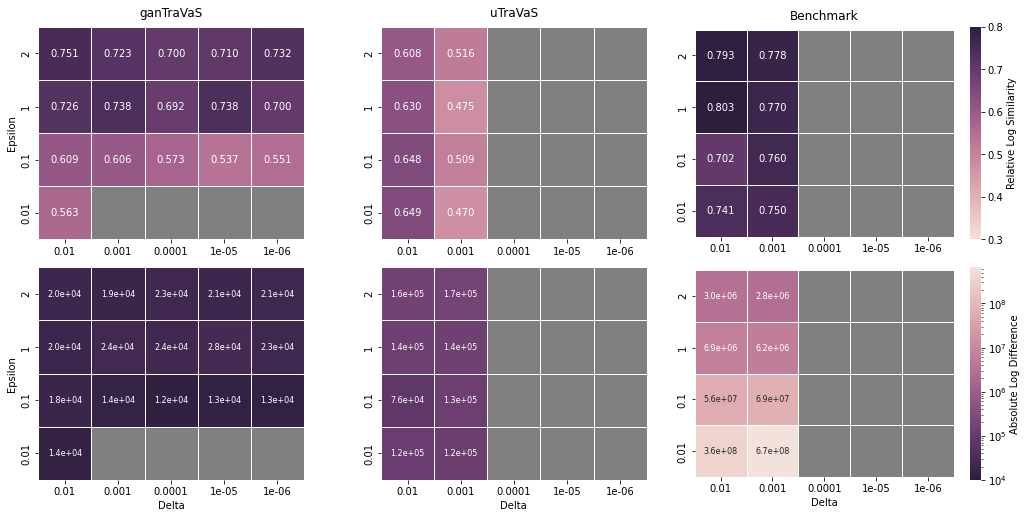

In [6]:
# create plots
f, ax = plt.subplots(2, 3, figsize=(14.8, 7.3))
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
cmap_r = sns.cubehelix_palette(as_cmap=True, light=.9, reverse=True)
cmap.set_bad('grey', 1.)
cmap_r.set_bad('grey', 1.)
ax[0,0] = sns.heatmap(util_gan, ax=ax[0,0], vmin=0.3, vmax=0.8, cmap=cmap, square=True, annot=True, cbar=False, fmt='.3f', yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], mask=np.isnan(util_gan), linewidths=.5)
ax[0,1] = sns.heatmap(util_trav, ax=ax[0,1], vmin=0.3, vmax=0.8, cmap=cmap, square=True, annot=True, fmt='.3f', cbar=False, yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], mask=np.isnan(util_trav), linewidths=.5)
ax[0,2] = sns.heatmap(util_bench, ax=ax[0,2], vmin=0.3, vmax=0.8, cmap=cmap, square=True, annot=True, fmt='.3f', cbar=True, yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], mask=np.isnan(util_bench), linewidths=.5, cbar_kws={'label': 'Relative Log Similarity'})
ax[1,0] = sns.heatmap(cost_gan, ax=ax[1,0], cmap=cmap_r, square=True, norm=LogNorm(vmin=1e4, vmax=np.nanmax(cost_bench)), annot=True, cbar=False, fmt='.1e', yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], mask=np.isnan(cost_gan), linewidths=.5, annot_kws={"fontsize":8})
ax[1,1] = sns.heatmap(cost_trav, ax=ax[1,1], cmap=cmap_r, square=True, norm=LogNorm(vmin=1e4, vmax=np.nanmax(cost_bench)), annot=True, cbar=False, fmt='.1e', yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], mask=np.isnan(cost_trav), linewidths=.5, annot_kws={"fontsize":8})
ax[1,2] = sns.heatmap(cost_bench, ax=ax[1,2], cmap=cmap_r, norm=LogNorm(vmin=1e4, vmax=np.nanmax(cost_bench)), square=True, annot=True, fmt='.1e', cbar=True, yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], mask=np.isnan(cost_bench), linewidths=.5, cbar_kws={'label': 'Absolute Log Difference'}, annot_kws={"fontsize":8})
ax[0,0].set_title('ganTraVaS', pad=10)
ax[0,1].set_title('uTraVaS', pad=10)
ax[0,2].set_title('Benchmark', pad=10)
ax[1,0].set(xlabel="Delta", ylabel="Epsilon")
ax[0,0].set(ylabel="Epsilon")
ax[1,1].set(xlabel="Delta")
ax[1,2].set(xlabel="Delta")
f.tight_layout()
plt.savefig("Sepsis_data-util.pdf")

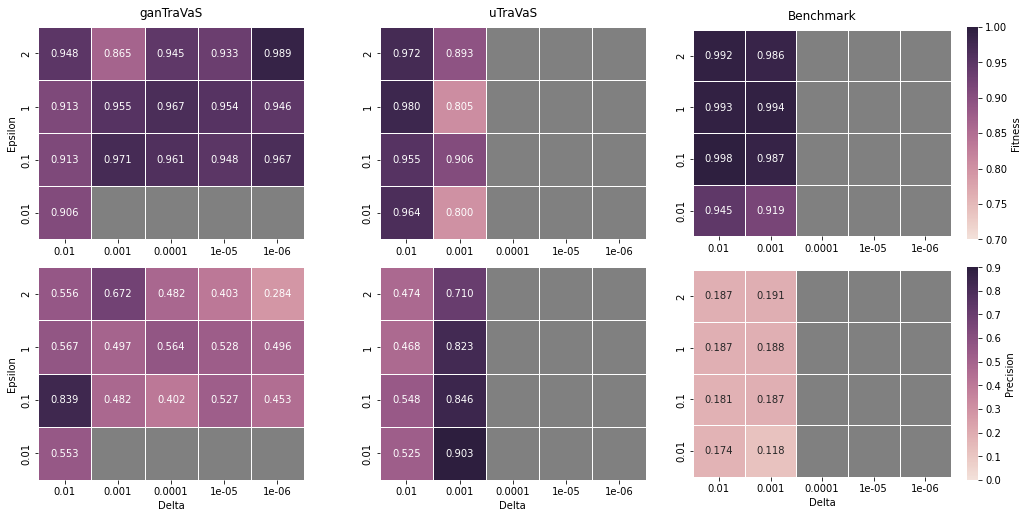

In [10]:
# create plots
f, ax = plt.subplots(2, 3, figsize=(14.8, 7.3))
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
cmap.set_bad('grey', 1.)
ax[0,0] = sns.heatmap(fit_gan_dp, ax=ax[0,0], vmin=0.7, vmax=1, cmap=cmap, square=True, annot=True, cbar=False, fmt='.3f', yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], mask=np.isnan(fit_gan_dp), linewidths=.5)
ax[0,1] = sns.heatmap(fit_trav_dp, ax=ax[0,1], vmin=0.7, vmax=1, cmap=cmap, square=True, annot=True, cbar=False, fmt='.3f', yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], mask=np.isnan(fit_trav_dp), linewidths=.5)
ax[0,2] = sns.heatmap(fit_bench_dp, ax=ax[0,2], vmin=0.7, vmax=1, cmap=cmap, square=True, annot=True, fmt='.3f', cbar=True, yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], mask=np.isnan(fit_bench_dp), linewidths=.5, cbar_kws={'label': 'Fitness'})
ax[1,0] = sns.heatmap(prec_gan_dp, ax=ax[1,0], cmap=cmap, square=True, vmin=0, vmax=0.9, annot=True, cbar=False, fmt='.3f', yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], mask=np.isnan(prec_gan_dp), linewidths=.5)
ax[1,1] = sns.heatmap(prec_trav_dp, ax=ax[1,1], cmap=cmap, square=True, vmin=0, vmax=0.9, annot=True, cbar=False, fmt='.3f', yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], mask=np.isnan(prec_trav_dp), linewidths=.5)
ax[1,2] = sns.heatmap(prec_bench_dp, ax=ax[1,2], cmap=cmap, vmin=0, vmax=0.9, square=True, annot=True, fmt='.3f', cbar=True, yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], linewidths=.5, mask=np.isnan(prec_bench_dp), cbar_kws={'label': 'Precision'})
ax[0,0].set_title('ganTraVaS', pad=10)
ax[0,1].set_title('uTraVaS', pad=10)
ax[0,2].set_title('Benchmark', pad=10)
ax[1,0].set(xlabel="Delta", ylabel="Epsilon")
ax[0,0].set(ylabel="Epsilon")
ax[1,1].set(xlabel="Delta")
ax[1,2].set(xlabel="Delta")
f.tight_layout()
plt.savefig("Sepsis_result-util-dp.pdf")

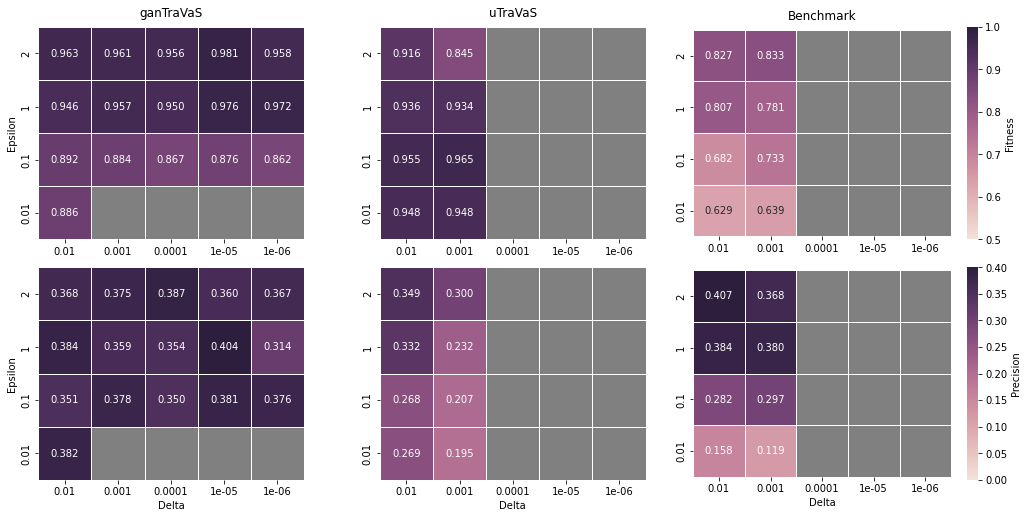

In [14]:
# create plots
f, ax = plt.subplots(2, 3, figsize=(14.8, 7.3))
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
cmap.set_bad('grey', 1.)
ax[0,0] = sns.heatmap(fit_gan_nondp, ax=ax[0,0], vmin=0.5, vmax=1, cmap=cmap, square=True, annot=True, cbar=False, fmt='.3f', yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], mask=np.isnan(fit_gan_nondp), linewidths=.5)
ax[0,1] = sns.heatmap(fit_trav_nondp, ax=ax[0,1], vmin=0.5, vmax=1, cmap=cmap, square=True, annot=True, cbar=False, fmt='.3f', yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], mask=np.isnan(fit_trav_nondp), linewidths=.5)
ax[0,2] = sns.heatmap(fit_bench_nondp, ax=ax[0,2], vmin=0.5, vmax=1, cmap=cmap, square=True, annot=True, fmt='.3f', cbar=True, yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], mask=np.isnan(fit_bench_nondp), linewidths=.5, cbar_kws={'label': 'Fitness'})
ax[1,0] = sns.heatmap(prec_gan_nondp, ax=ax[1,0], cmap=cmap, square=True, vmin=0, vmax=0.4, annot=True, cbar=False, fmt='.3f', yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], mask=np.isnan(prec_gan_nondp), linewidths=.5)
ax[1,1] = sns.heatmap(prec_trav_nondp, ax=ax[1,1], cmap=cmap, square=True, vmin=0, vmax=0.4, annot=True, cbar=False, fmt='.3f', yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], mask=np.isnan(prec_trav_nondp), linewidths=.5)
ax[1,2] = sns.heatmap(prec_bench_nondp, ax=ax[1,2], cmap=cmap, vmin=0, vmax=0.4, square=True, annot=True, fmt='.3f', cbar=True, yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], linewidths=.5, mask=np.isnan(prec_bench_nondp), cbar_kws={'label': 'Precision'})
ax[0,0].set_title('ganTraVaS', pad=10)
ax[0,1].set_title('uTraVaS', pad=10)
ax[0,2].set_title('Benchmark', pad=10)
ax[1,0].set(xlabel="Delta", ylabel="Epsilon")
ax[0,0].set(ylabel="Epsilon")
ax[1,1].set(xlabel="Delta")
ax[1,2].set(xlabel="Delta")
f.tight_layout()
plt.savefig("Sepsis_result-util-nondp.pdf")